# Holt-Winters Methods
<strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

We'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa import holtwinters

In [2]:
df = pd.read_csv('airline_passengers.csv',index_col='Month',parse_dates=True)

In [3]:
df.dropna(inplace=True)
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

### Setting a DatetimeIndex Frequency
Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.<br>A full list of time series offset aliases can be found <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>here</a>.

In [4]:
df.index.freq = 'MS'

In [5]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

## Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

<div class="alert alert-danger"><strong>NOTE:</strong> For some reason, when <tt>optimized=False</tt> is passed into <tt>.fit()</tt>, the statsmodels <tt>SimpleExpSmoothing</tt> function shifts fitted values down one row. We fix this by adding <tt>.shift(-1)</tt> after <tt>.fittedvalues</tt></div>

In [8]:
span = 12
alpha = 2/(span+1)

In [9]:
df['EWMA-12'] = df['Thousands of Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [10]:
df

,Thousands of Passengers,EWMA-12
Month,,
1949-01-01,112,112.000000
1949-02-01,118,112.923077
1949-03-01,132,115.857988
1949-04-01,129,117.879836
1949-05-01,121,118.359861
...,...,...
1960-08-01,606,494.898619
1960-09-01,508,496.914216
1960-10-01,461,491.388952


In [18]:
model = holtwinters.SimpleExpSmoothing(df['Thousands of Passengers'])

In [20]:
fitted_model = model.fit(smoothing_level=alpha, optimized=False)

In [21]:
fitted_model.fittedvalues

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    112.923077
1949-04-01    115.857988
1949-05-01    117.879836
                 ...    
1960-08-01    474.698368
1960-09-01    494.898619
1960-10-01    496.914216
1960-11-01    491.388952
1960-12-01    475.790652
Freq: MS, Length: 144, dtype: float64

<div class="alert alert-danger"><strong>NOTE:</strong> For some reason, when <tt>optimized=False</tt> is passed into <tt>.fit()</tt>, the statsmodels <tt>SimpleExpSmoothing</tt> function shifts fitted values down one row. We fix this by adding <tt>.shift(-1)</tt> after <tt>.fittedvalues</tt></div>

In [23]:
df['SES-12'] = fitted_model.fittedvalues.shift(-1)

In [24]:
df

,Thousands of Passengers,EWMA-12,SES-12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861
...,...,...,...
1960-08-01,606,494.898619,494.898619
1960-09-01,508,496.914216,496.914216
1960-10-01,461,491.388952,491.388952


In [ ]:
# df['SES12'] = holtwinters.SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

## Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

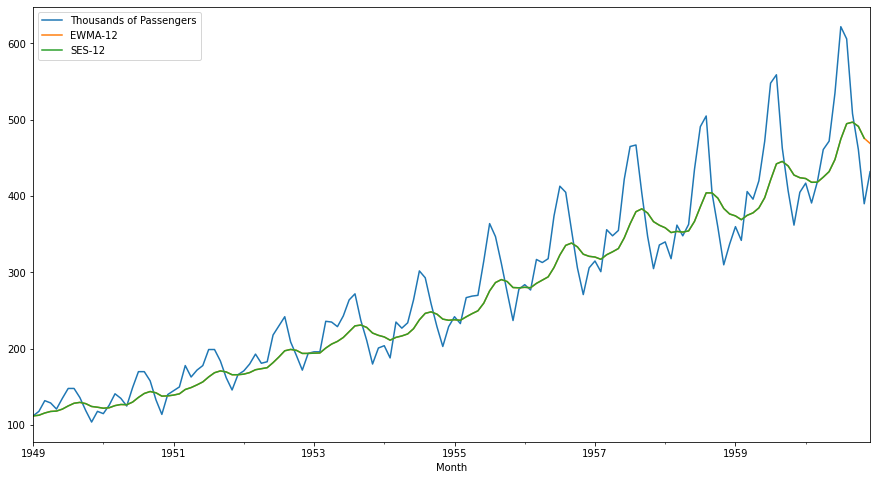

In [26]:
df.plot(figsize=(15,8));

Parameters
----------
**endog :** array_like
    The time series to model.
    
**trend :** {"add", "mul", "additive", "multiplicative", None}, optional
    Type of trend component.
    
**damped_trend :** bool, optional
    Should the trend component be damped.
    
**seasonal :** {"add", "mul", "additive", "multiplicative", None}, optional
    Type of seasonal component.
    
**seasonal_periods :** int, optional
    The number of periods in a complete seasonal cycle, e.g., 4 for
    quarterly data or 7 for daily data with a weekly cycle.
    
**initialization_method :** str, optional
    Method for initialize the recursions. One of:

    * None
    * 'estimated'
    * 'heuristic'
    * 'legacy-heuristic'
    * 'known'

In [27]:
df['DES_add_12'] = holtwinters.ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)

In [28]:
df

,Thousands of Passengers,EWMA-12,SES-12,DES_add_12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.102394
1949-02-01,118,112.923077,112.923077,120.040657
1949-03-01,132,115.857988,115.857988,134.001539
1949-04-01,129,117.879836,117.879836,131.085845
1949-05-01,121,118.359861,118.359861,123.110263
...,...,...,...,...
1960-08-01,606,494.898619,494.898619,608.168786
1960-09-01,508,496.914216,496.914216,510.571382
1960-10-01,461,491.388952,491.388952,463.313463


In [29]:
df.columns

Index(['Thousands of Passengers', 'EWMA-12', 'SES-12', 'DES_add_12'], dtype='object')

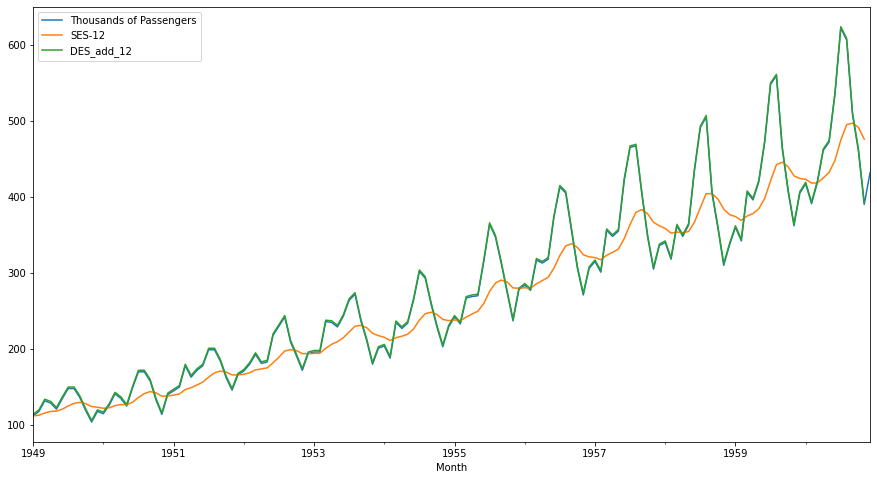

In [31]:
df[['Thousands of Passengers', 'SES-12', 'DES_add_12']].plot(figsize=(15,8));

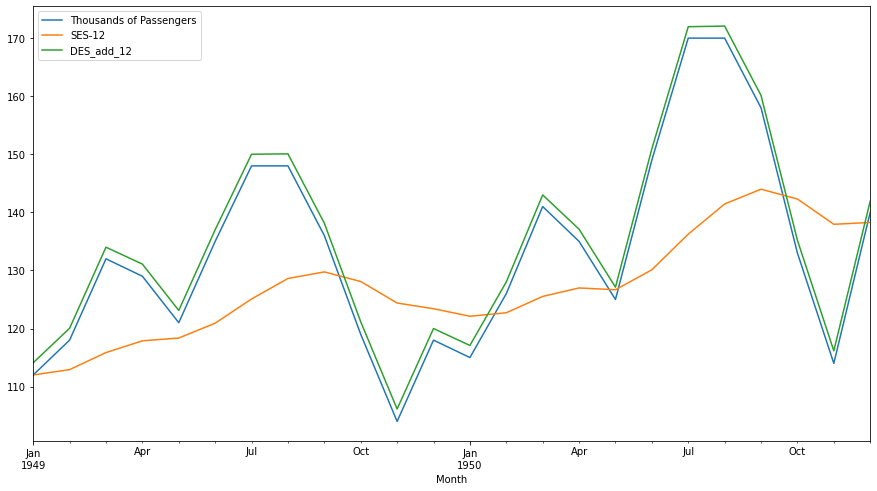

In [32]:
df[['Thousands of Passengers', 'SES-12', 'DES_add_12']].iloc[:24].plot(figsize=(15,8));

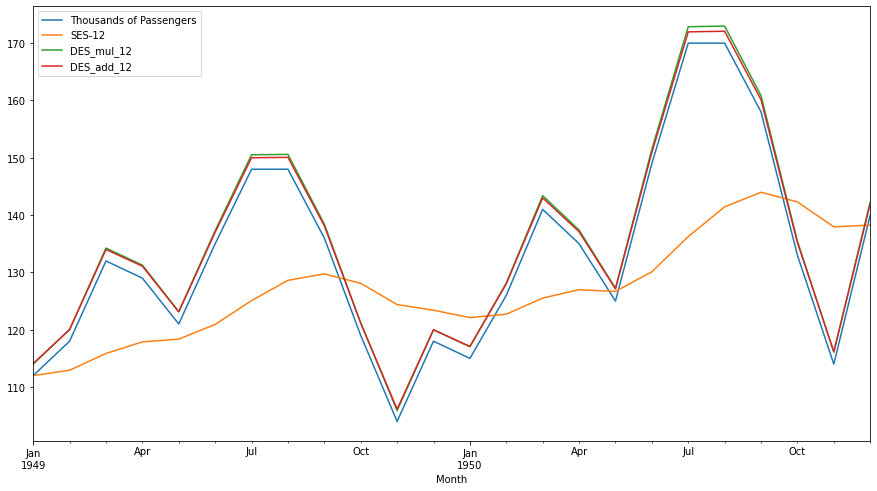

In [36]:
df['DES_mul_12'] = holtwinters.ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df[['Thousands of Passengers', 'SES-12', 'DES_mul_12','DES_add_12']].iloc[:24].plot(figsize=(15,8));

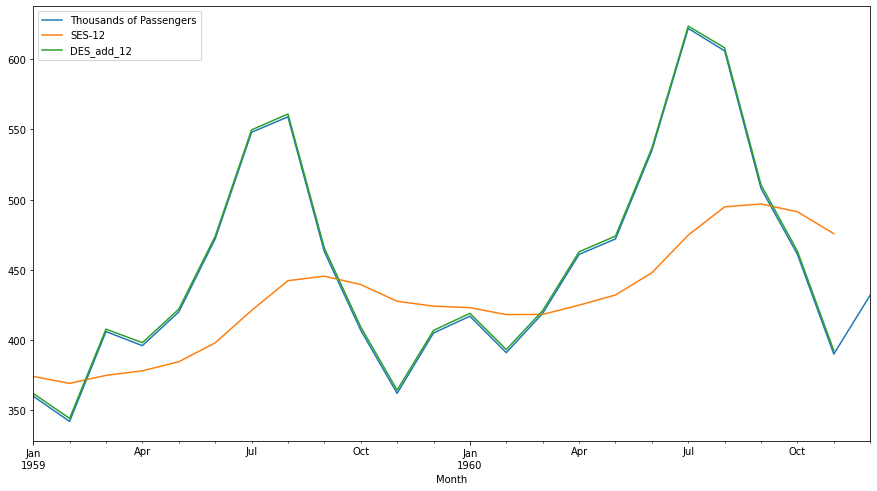

In [33]:
df[['Thousands of Passengers', 'SES-12', 'DES_add_12']].iloc[-24:].plot(figsize=(15,8));

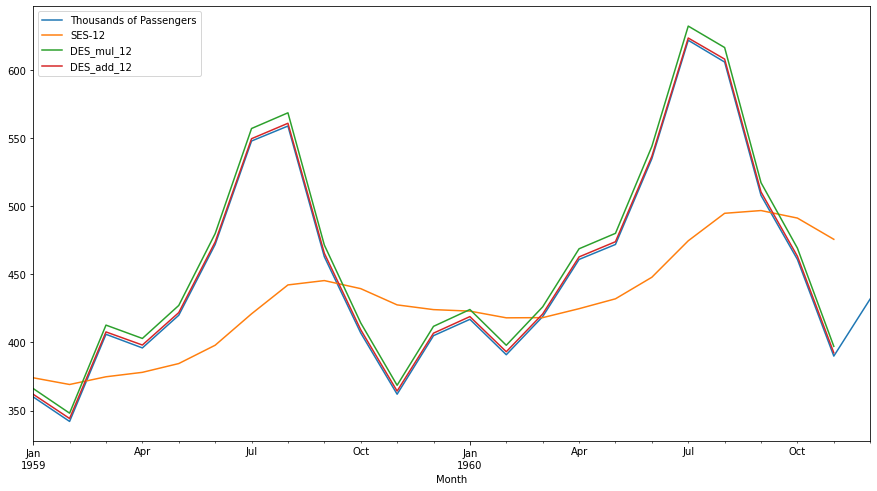

In [37]:
df[['Thousands of Passengers', 'SES-12', 'DES_mul_12','DES_add_12']].iloc[-24:].plot(figsize=(15,8));

## Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 



In [39]:
df['TES_mul_12'] = holtwinters.ExponentialSmoothing(df['Thousands of Passengers'], trend='mul', 
                                                    seasonal='mul', seasonal_periods=12).fit().fittedvalues

In [40]:
df

,Thousands of Passengers,EWMA-12,SES-12,DES_add_12,DES_mul_12,TES_mul_12
Month,,,,,,
1949-01-01,112,112.000000,112.000000,114.102394,113.990701,111.595648
1949-02-01,118,112.923077,112.923077,120.040657,120.031669,118.842606
1949-03-01,132,115.857988,115.857988,134.001539,134.235979,133.333853
1949-04-01,129,117.879836,117.879836,131.085845,131.270786,127.899963
1949-05-01,121,118.359861,118.359861,123.110263,123.156267,120.979016
...,...,...,...,...,...,...
1960-08-01,606,494.898619,494.898619,608.168786,616.673652,629.400753
1960-09-01,508,496.914216,496.914216,510.571382,517.378618,511.999934
1960-10-01,461,491.388952,491.388952,463.313463,469.290950,448.034716


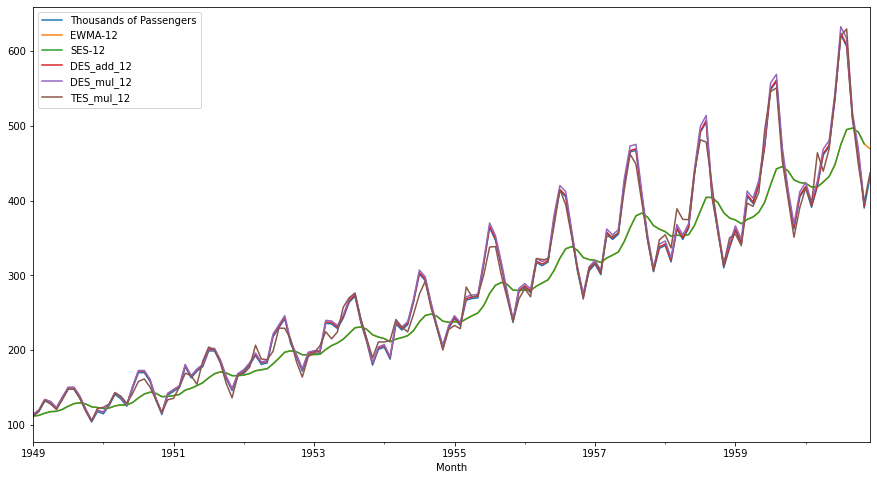

In [42]:
df.plot(figsize=(15,8));

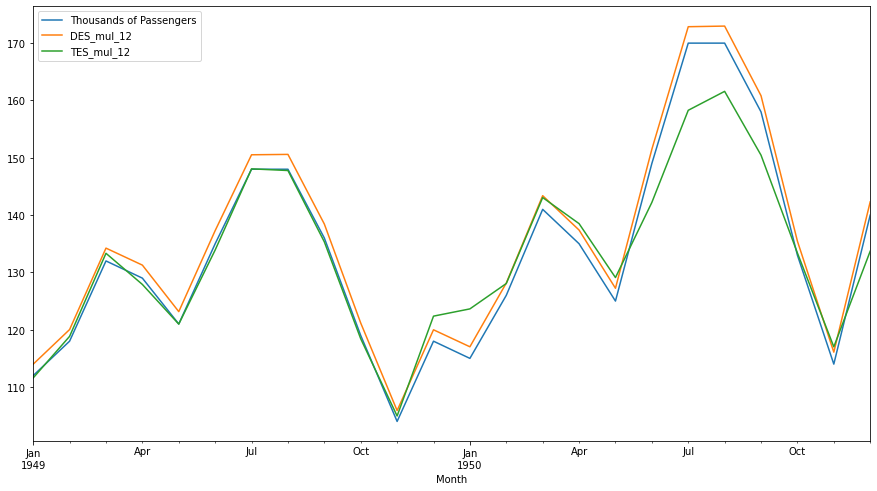

In [45]:
df[['Thousands of Passengers', 'DES_mul_12', 'TES_mul_12']].iloc[:24].plot(figsize=(15,8));

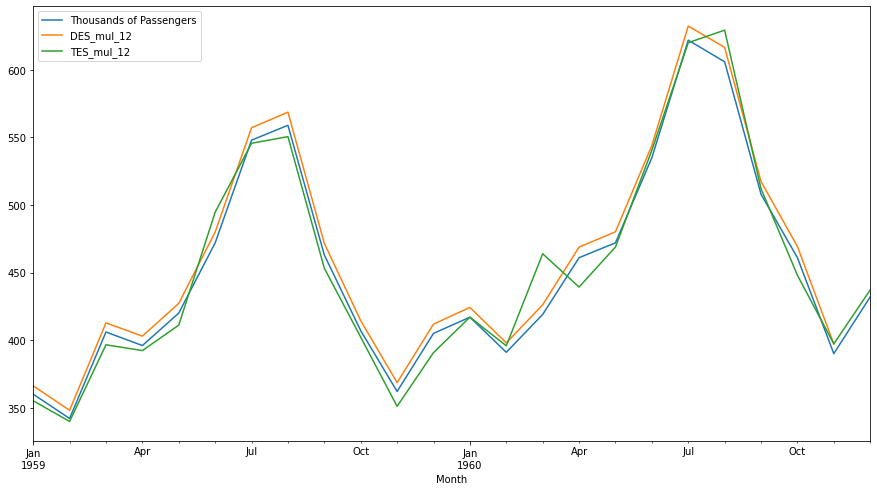

In [46]:
df[['Thousands of Passengers', 'DES_mul_12', 'TES_mul_12']].iloc[-24:].plot(figsize=(15,8));

Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key here is to consider what comes next - <em>forecasting</em>. We'll see that having the ability to predict fluctuating seasonal patterns greatly improves our forecast.